<div class="alert alert-block alert-info">
    <b>Projet 5 | Segmentez des clients d'un site e-commerce<br></b>
    <p style="color:#8B0000;">
        Partie 3 |  Stabilité & Maintenance </p>
</div>

# Stabilité | Maintenance

Le but de cet exercice de maintenance est d'identifier la **"durée d'obsolesence"** du modèle de clustering qui est entrainé : on identifie alors que les prédictions de clusterisation du modèle précédent ne sont plus aussi précises qu'en entraînant un nouveau modèle sur base des nouvelles données. On doit donc déterminer la durée cible entre **2 entrainements de modèle**.

**Les clusters à comparer sont issus des entrainements :**
-  des modèles M0, M1, etc... 
-  qui sont réalisés à T0, T1, etc... 
-  pour des fichiers clients F0, F1, etc...
-  qui donne la liste des clusters C0, C1, etc...

**A T1, on va donc comparer :**
-  le cluster **C1_M0** créé via un « predict » du **modèle initial M0** créé à **T0**, et 
-  le cluster **C1_new** créé via un « fit » du **nouveau modèle M1** créé en **T1**.

**Schématiquement, on peut représenter l'enchainement ainsi :**
T0 --> C0=M0.fit(F0)<br>
T1 --> C1_new = M1.fit(F1) c'est la nouvelle clusterisation suite à nouvel entrainement<br>
T1 --> C1_init = M0.predict(F1) c'est la prédiction de clusterisation issue de l'entrainement M0

# Préparation notebook | Import des packages et données

Notebook variables reset for each complete execution of this code :

In [110]:
%reset -f

## 1 | Vérification de la version de Python

In [111]:
!python -V

Python 3.7.0


## 2 | Installation des nouveaux packages nécessaire

In [112]:
# installing chart_studio
!pip install chart_studio

In [113]:
# installing yellowbrick.cluster
!pip install yellowbrick

## 3 | Import des packages utiles au projet

In [114]:
# Modules classiques d'analyse exploratoire:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from pandas_profiling import ProfileReport
import missingno as msno
import scipy.stats as stats
import chart_studio as cs
import plotly.offline as po
import plotly.graph_objs as gobj

# Mathématiques
import math

# Manipulation fichiers et Interaction avec l'os / notebook
import os
import csv
import requests
import warnings
import json
import autopep8
from pickle import dump
from pickle import load
import re

# Manipulation de chaines de caractères
# from ast import literal_eval #abstract syntax tree
# from bs4 import BeautifulSoup as soup

# Données géographiques et géométriques
# import geopy
# from geopy.distance import geodesic
# import re
# from geopy.extra.rate_limiter import RateLimiter
# from shapely.geometry import Point
# import folium
# import folium.plugins

# Manipulations temporelles
import datetime as dt
# from tqdm import tqdm
# from tqdm.notebook import tqdm, trange
import time

# Extraction web
# from urllib.request import urlopen as uReq # Web client
# import urllib.request # Web client
# from importlib_metadata import version

# Feature engineering
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn import decomposition

# Modelling
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
# un module pour faire du clustering
# et un pour calculer le coefficient de silhouette
from sklearn import cluster, metrics

## 4 | Vérification des versions de package disponibles

In [115]:
!pip list

Package                           Version
--------------------------------- ------------
argon2-cffi                       21.3.0
argon2-cffi-bindings              21.2.0
attrs                             21.4.0
autopep8                          1.6.0
backcall                          0.2.0
beautifulsoup4                    4.11.1
bleach                            4.1.0
branca                            0.5.0
bs4                               0.0.1
certifi                           2021.10.8
cffi                              1.15.0
charset-normalizer                2.0.12
chart-studio                      1.1.0
colorama                          0.4.4
cycler                            0.11.0
debugpy                           1.5.1
decorator                         5.1.1
defusedxml                        0.7.1
distlib                           0.3.4
entrypoints                       0.4
filelock                          3.6.0
folium                            0.12.1.post1
fonttools      

## 5 | Fonctions utiles au projet 

Fonction **sauvegarde des figures** dans le répertoire courant :

In [116]:
# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "unsupervised_learning"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)


def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

Fonction de **préparation des features** en vue d'une **Log-transformation** (pas de valeurs négatives) :

In [117]:
# Handle negative and zero values so as to handle infinite numbers during log transformation
def handle_neg_n_zero(num):
    if num <= 0:
        return 1
    else:
        return num

Fonction de **création des fichiers client** à partir des données source et **à la date cible** fournie :

In [118]:
def fichier_clients(date):
    """ Concatène les fichiers sources,
    identifie et suprimme les individus avec des manquants,
    crée et formate les features, en passe certains au log, 
    filtre sur les dates de commande inférieures à la date demandée,
    et regroupe en un fichier par numéro de client unique.
    """
    global Latest_Date

    # chargement des dataframes
    customers = pd.read_csv("olist_customers_dataset.csv")
    items = pd.read_csv("olist_order_items_dataset.csv")
    payments = pd.read_csv("olist_order_payments_dataset.csv")
    reviews = pd.read_csv("olist_order_reviews_dataset.csv")
    orders = pd.read_csv("olist_orders_dataset.csv")

    # groupby de payments
    payments = payments.groupby(['order_id']).sum()

    # grouping items by order_id so to be able to merge
    # creating the new features using a dictionary for aggregation
    items = items.groupby('order_id').agg(
        nb_articles=('order_item_id', 'max'),
        nb_diff_products=('product_id', lambda x: len(np.unique(x))),
        price=('price', 'sum'),
        freight_value=('freight_value', 'sum'))

    # suppression des commandes en écart entre items, orders et payments
    order_items = items.index.unique().tolist()
    order_orders = orders.order_id.unique().tolist()
    orders_missing = set(order_orders).difference(set(order_items))
    mask = items.index.isin(orders_missing)
    before = items.shape[0]
    items = items[~mask]
    after = items.shape[0]
    print('We removed', before-after, 'lines from the items dataframe.')
    mask = orders['order_id'].isin(orders_missing)
    before = orders.shape[0]
    orders = orders[~mask]
    after = orders.shape[0]
    print('We removed', before-after, 'lines from the orders dataframe.')

    mask = payments.index.isin(orders_missing)
    orders_missing_items = set(items.index.unique().tolist()).difference(
        set(payments.index.unique().tolist()))
    mask1 = payments.index.isin(orders_missing_items)
    before = payments.shape[0]
    payments = payments[(~mask) & (~mask1)]
    after = payments.shape[0]
    print('We removed', before-after, 'lines from the payments dataframe.')
    gap_abs = items.price.sum() + items.freight_value.sum() - \
        payments.payment_value.sum()
    gap_perc = gap_abs / payments.payment_value.sum()*100
    print('On constate un écart total en valeur de', round(gap_abs, 2), 'Reais, soit', round(gap_perc, 2),
          '% entre les données de payments et celles de items. \
      \nJe considère que cet écart est non significatif, nous pouvons donc exploiter les données')

    # merge des différents dataframe
    data = pd.merge(orders, payments, how='left', on='order_id')
    data = pd.merge(data, customers, how='left', on='customer_id')
    data = pd.merge(data, reviews, how='left', on='order_id')
    data = pd.merge(data, items, how='left', on='order_id')
    print(data.shape)
    print('The dataframe data contains for the moment', data["customer_unique_id"].nunique(
    ), 'customer_unique_id.\nWe saw earlier that unique customers are identified by the feature customer_unique_id')

    # traitement des manquants
    data.replace(to_replace='^NaN$', value=np.nan,
                 regex=True, inplace=True)
    before = data.shape[0]
    data.drop(data[data['payment_value'].isnull()].index, inplace=True)
    print('Nous avons retiré', before -
          data.shape[0], 'individu(s) sans payment_value retirés du jeu de données.')
    data.loc[data['payment_sequential'].isnull(), 'payment_sequential'] = 0
    data.loc[data['review_score'].isnull(), 'review_score'] = "None"
    mask = data['review_score'] == 'None'
    before = data.shape[0]
    data = data[~mask]
    after = data.shape[0]
    print(before-after, 'individu(s) sans review_score retirés du jeu de données.')

    # tri colonnes utiles
    cols_to_keep = ['order_id', 'customer_id', 'order_status',
                    'order_purchase_timestamp', 'payment_value', 'customer_unique_id', 'review_score',
                    'nb_articles', 'nb_diff_products']
    data = data.loc[:, cols_to_keep]
    print('Avant de filtrer sur la date demandée nous avons construit une base de données contenant', data.shape[0],
          'commandes pour un CA de', round(data['payment_value'].sum(), 2), 'Reais.')

    # création des features Recency, Frequency et Monetary
    # set last invoice date to calculate recency
    data['order_purchase_timestamp'] = pd.to_datetime(
        data['order_purchase_timestamp'])
    Latest_Date = data['order_purchase_timestamp'].max()
    data['review_score'] = pd.to_numeric(data['review_score'])

    # filtre du fichier à la date demandée
    data = data.loc[data['order_purchase_timestamp'] <= date, :]

    # regroupement par customer_unique_id
    data = data.groupby('customer_unique_id').agg(
        recency=('order_purchase_timestamp', days_latest),
        frequency=('order_id', 'count'),
        monetary=('payment_value', 'sum'),
        satisfaction=('review_score', 'mean'),
        nb_articles=('nb_articles', 'mean'),
        nb_diff_products=('nb_diff_products', 'mean'),
        last_purch=('order_purchase_timestamp', 'max'),
    )
    data['aver_basket'] = data.monetary / data.frequency

    # ajout des colonnes log-transformées
    # Apply handle_neg_n_zero function to Recency and Monetary columns
    data['recency_log'] = [handle_neg_n_zero(x) for x in data.recency]
    data['aver_basket_log'] = [handle_neg_n_zero(x) for x in data.monetary]
    data['monetary_log'] = [handle_neg_n_zero(x) for x in data.monetary]

    # Perform Log transformation to bring data into normal or near normal distribution
    data[['recency_log', 'aver_basket_log', 'monetary_log']] = data[['recency_log', 'aver_basket_log', 'monetary_log']].apply(
        np.log, axis=1).round(3)

    return data


def days_latest(x):
    return (Latest_Date - x.max()).days

## 6 | Mise en page et réglages divers du notebook

In [119]:
# Modification des affichages de colonnes, lignes et largeurs de colonnes pour bien visualiser les colonnes
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 20)
pd.set_option('display.max_colwidth', None)

# Affichage avec la bibliothèque graphique intégrée à Notebook:
%matplotlib inline

# To plot pretty figures
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Format des graphiques seaborn
sns.set_theme(style="whitegrid")

# to make this notebook's output stable across runs
np.random.seed(42)

## 7 | Chargement des données data_raw pour évaluation de la fréquence mise à jour

Chargement du contenu du fichier **data_raw.pkl** via la fonction **load_data**:

In [120]:
def load_data():
    data_raw = pd.read_pickle('data_raw.pkl')
#     data = pd.read_pickle('data2.pkl')
    return (data_raw)
#     return (data, data_raw)

In [121]:
data_raw = load_data()
# data, data_raw = load_data()

# 9 | Méthodologie suivie

## Périodes envisageables de mise à jour selon la quantité de nouvelles commandes enregistrées

In [122]:
data_raw.order_purchase_timestamp = pd.to_datetime(data_raw.order_purchase_timestamp)
data_raw.set_index('order_purchase_timestamp', drop=False, inplace=True)

In [123]:
# Nombre de commandes par an
data_raw.groupby(data_raw.index.year)['order_id'].agg("count")

order_purchase_timestamp
2016      306
2017    44205
2018    53405
Name: order_id, dtype: int64

In [124]:
# Nombre de commandes par trimestre
data_raw.groupby([data_raw.index.year,
                   data_raw.index.quarter]) \
                   ['order_id'].agg("count")

order_purchase_timestamp  order_purchase_timestamp
2016                      3                               2
                          4                             304
2017                      1                            5122
                          2                            9192
                          3                           12404
                          4                           17487
2018                      1                           20918
                          2                           19831
                          3                           12656
Name: order_id, dtype: int64

In [125]:
# Nombre de commandes par mois
data_raw.groupby([data_raw.index.year,
                   data_raw.index.quarter,
                   data_raw.index.month]) \
                   ['order_id'].agg("count")

order_purchase_timestamp  order_purchase_timestamp  order_purchase_timestamp
2016                      3                         9                              2
                          4                         10                           303
                                                    12                             1
2017                      1                         1                            779
                                                    2                           1722
                                                                                ... 
2018                      2                         5                           6819
                                                    6                           6134
                          3                         7                           6228
                                                    8                           6427
                                                    9                    

In [126]:
data_raw.order_purchase_timestamp.max()

Timestamp('2018-09-03 09:06:57')

In [127]:
data_raw.order_purchase_timestamp.min()

Timestamp('2016-09-04 21:15:19')

In [128]:
data_raw[data_raw['order_purchase_timestamp'] > '2017-12-31'].shape[0]

53478

In [129]:
data_raw[(data_raw['order_purchase_timestamp'] > '2017-12-31') &
         (data_raw['order_purchase_timestamp'] <= '2018-03-31')].shape[0]

20825

In [130]:
data_raw[(data_raw['order_purchase_timestamp'] > '2018-04-01') &
         (data_raw['order_purchase_timestamp'] <= '2018-07-31')].shape[0]

25742

Tous les 4 mois un nombre comparable de commandes est enregistré. Nous allons commencer avec cette fréquence.
Au besoin nous réduirons la durée entre chaque maintenance, jusqu'à obtenir le résultat le plus satisfaisant.

## Méthode et étapes

Nous avons maintenant retenu un modèle de clusterisation : 
-  modèle : **Kmeans**
-  k = **5 clusters**,
-  sur base des **features RAMS**.

Nous devons déterminer le nombre de jours minimal après lequel le modèle de prédiction initialement entrainé n'est plus pertinent par rapport à l'évolution des comportements d'achat de la clientèle.<br>

Ce nombre de jours sera la fréquence de mise à jour du modèle de clustering.

Les données brutes s'étendent de Septembre 2016 à début Septembre 2018 et **couvrent une période d'environ 2 ans**.<br>
Nous allons donc procéder par itération et envisager d'abord une **maintenance du modèle tous les 4 mois**, et pour cela allons réaliser :  

-  l'entrainement d'un 1er **modèle M0 au 31/12/2017** comprenant les commandes avant cette date (**période P0**)
-  l'entrainement d'un 2e **modèle M1 au 30/04/2018** comprenant les commandes avant cette date (**période P1**)
-  l'entrainement d'un 3e **modèle M2 au 31/08/2018** comprenant les commandes avant cette date (**période P2**)

Nous comparerons pour la **période P1** (du 31/12/2017 au 30/04/2018):

-  les clusters issus de la **prédiction du modèle M0** avec les données clients F1 de la période P1 (**predict**)
-  les clusters issus de l'**entrainement d'un modèle M1** avec les données client F1 de la période P1 (**fit**, données à standardiser avec le scaler de P0)

Puis nous comparerons pour la **période P2** (du 31/12/2017 au 31/08/2018):

-  les clusters issus de la prédiction du modèle M1 avec les données clients F2 de la période P2 (**predict**)
-  les clusters issus de l'entrainement d'un modèle M2 avec les données client F2 de la période P2 (**fit**, données à standardiser avec le scaler de P1)

**Comparaison des clusters :** J'utiliserai **l’ARI (Adjusted Rand Index)** pour mesurer la divergence entre les clusters, car cet indicateur est indépendant de la numérotation des clusters. J'observerai l’évolution de l’ARI entre chaque période simulée.<br>

Si l’**ARI devient inférieur à 0.8**, c'est qu'il faut **augmenter la fréquence d'entraînement** des modèles.<br>
Dans ce cas la durée sera réduite et je réaliserai le **même exercice avec 3 mois au lieu de 4**, et ainsi de suite **jusqu'à obtenir un ARI >= 0.8**...

En cas d'augmentation de la fréquence à tous les 3 mois, voici les dates à considérer

-  l'entrainement d'un 1e **modèle M0 au 28/02/2018** comprenant les commandes avant cette date (**période P0**)
-  l'entrainement d'un 2e **modèle M1 au 31/05/2018** comprenant les commandes avant cette date (**période P1**)
-  l'entrainement d'un 3e **modèle M2 au 31/08/2018** comprenant les commandes avant cette date (**période P2**)


En cas d'augmentation de la fréquence à tous les 2 mois, voici les dates à considérer

-  l'entrainement d'un 1er **modèle M0 au 30/04/2018** comprenant les commandes avant cette date (**période P0**)
-  l'entrainement d'un 2e **modèle M1 au 30/06/2018** comprenant les commandes avant cette date (**période P1**)
-  l'entrainement d'un 3e **modèle M2 au 31/08/2018** comprenant les commandes avant cette date (**période P2**)



## Préparation à l'enregistrement des résultats

In [131]:
results = pd.DataFrame({'ARI_T1': "", 'ARI_T2': ""},
                       index=['M_4_mths', 'M_3_mths', 'M_2_mths'])

In [132]:
results

,ARI_T1,ARI_T2
M_4_mths,,
M_3_mths,,
M_2_mths,,


In [133]:
results.index.names = ['ARI']

# 10 | Fréquence maintenance = 4 mois

## 10.1 | Préparation fichier F0, entrainement modèle M0, clusterisation C0

### 10.1.1 | Préparation du fichier clients F0 - via la fonction fichier_clients()

J'ai défini une fonction **fichier_clients()** qui crée le fichier clients Fi à date Ti, à partir des divers fichiers sources, et pour les commandes passées jusqu’à la date Ti.

-  la variable d'entrée de cette fonction est la date Ti de la dernière commande.

-  la fonction réalise le filtrage des commandes jusqu’à la date Ti et crée les features.

-  la fonction retourne le jeu de données data par client unique sous la forme d'un dataframe.

In [134]:
date = '2017-12-31'

In [135]:
date = pd.to_datetime(date)

In [136]:
F0 = fichier_clients(date)

We removed 0 lines from the items dataframe.
We removed 775 lines from the orders dataframe.
We removed 775 lines from the payments dataframe.
On constate un écart total en valeur de -2726.93 Reais, soit -0.02 % entre les données de payments et celles de items.       
Je considère que cet écart est non significatif, nous pouvons donc exploiter les données
(99214, 25)
The dataframe data contains for the moment 95420 customer_unique_id.
We saw earlier that unique customers are identified by the feature customer_unique_id
Nous avons retiré 1 individu(s) sans payment_value retirés du jeu de données.
749 individu(s) sans review_score retirés du jeu de données.
Avant de filtrer sur la date demandée nous avons construit une base de données contenant 98464 commandes pour un CA de 15774881.4 Reais.


In [137]:
F0.last_purch.max() < date

True

In [138]:
print('Ce fichier client ne compte bien que les commandes passées avant',
      date, '\ndate de dernière commande la plus récente :', F0.last_purch.max())

Ce fichier client ne compte bien que les commandes passées avant 2017-12-31 00:00:00 
date de dernière commande la plus récente : 2017-12-30 23:53:28


### 10.1.2 | Standardisation des features de F0

Here are the useful features selected for the model : 

In [139]:
useful_features = ['recency_log', 'aver_basket_log',
                   'monetary_log', 'satisfaction', 'nb_articles', 'nb_diff_products']

In [140]:
# Bring the data on same scale
scaler_F0 = StandardScaler()
Scaled_Data_F0 = scaler_F0.fit_transform(F0.loc[:, useful_features])

In [141]:
# Transform it back to dataframe
Scaled_Data_F0 = pd.DataFrame(
    Scaled_Data_F0, index=F0.index, columns=F0.loc[:, useful_features].columns)

In [142]:
Scaled_Data_RAMS_F0 = Scaled_Data_F0[[
    'recency_log', 'aver_basket_log', 'monetary_log', 'satisfaction']]

J'exporte le scaler_F0 au format pickle pour la suite :
-  partant du principe qu'en situation réelle nous n'aurons pas forcément toutes les données à l'avance, il conviendra de procéder ainsi (stockage du scaler / modèle sur disque et restore pour comparaison).

-  pour le charger lorsque les données seront disponibles, on pourra effectuer le code suivant : 
scaler_F0 = load(open('scaler_F0.pkl', 'rb'))

-  mais dans notre cas étant donnée que toutes les données sont disponibles à l'instant t nous garderons en mémoire vive les différents scalers et modèles pour effectuer nos comparaisons. 

In [143]:
# save the scaler
dump(scaler_F0, open('scaler_F0.pkl', 'wb'))

### 10.1.3 | Modélisation Kmeans M0 | sur base des données F0

In [144]:
X_F0 = Scaled_Data_RAMS_F0.values

X_F0 est déjà normalisé (avec Standard Scaler), nous n'avons donc pas besoin de réaliser cette étape à nouveau ici.

In [145]:
print(X_F0.shape)

(43095, 4)


Je vais maintenant créer un clustering à l'aide du **modèle k-means**.<br>
Il contiendra comme identifié précédemment **5 clusters**, la taille cible.<br>
Je vais représenter les clusters et calculer un **coefficient de silhouette** pour pouvoir comparer l'évolution dans le temps.

In [146]:
mpl.rcParams["figure.figsize"] = (9, 6)

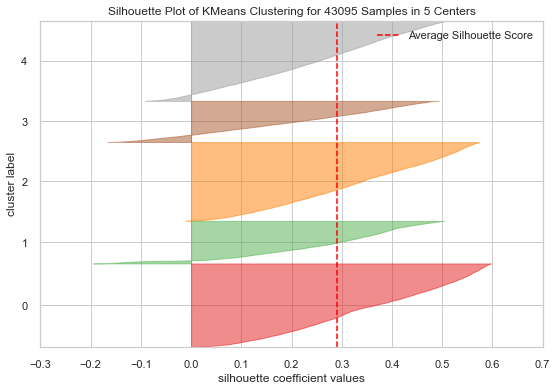

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 43095 Samples in 5 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [147]:
# Instantiate the clustering model and visualizer
model = KMeans(5)
visualizer = SilhouetteVisualizer(model)

visualizer.fit(X_F0)    # Fit the data to the visualizer
visualizer.poof()    # Draw/show/poof the data

In [148]:
print('Le silhouette score du modèle M0 est de',
      round(visualizer.silhouette_score_, 3))

Le silhouette score du modèle M0 est de 0.29


Pour regarder à quoi ressemble les clusters, j'utilise une ACP pour projeter les données sur 3 dimensions. J'utilise pour cela le module décomposition de scikit-learn.

In [149]:
pca = decomposition.PCA(n_components=2)
pca.fit(X_F0)
print(pca.explained_variance_ratio_.cumsum())
X_trans_F0 = pca.transform(X_F0)

[0.50115881 0.75710862]


J'ai affiché le pourcentage de variance expliquée par la première composante et par les deux premières composantes cumulées.

On a donc près de 76% de la variance totale qui sont expliquées par ces 2 premières composantes.

Il est donc possible d'utiliser ces deux premières composantes pour représenter les données.

J'affiche les données projetées selon ces deux dimensions, colorées selon le cluster auquel elles appartiennent, pour 5 clusters.

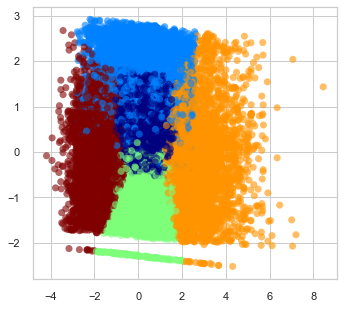

In [150]:
# je crée une figure
fig = plt.figure(figsize=(12, 5))

# Je détermine la clusterisation C0 des données F0 sur base du modèle M0
M0 = cluster.KMeans(n_clusters=5, random_state=42)
C0 = M0.fit(X_F0)
ax = fig.add_subplot(122)
ax.scatter(X_trans_F0[:, 0], X_trans_F0[:, 1], c=M0.labels_,
           edgecolors="none", cmap="jet", alpha=0.6, s=50)

**Note :** La partie centrale de la population du graphe forme maintenant le cinquième cluster.

Comme cela se passerait dans la vie réelle, nous allons maintenant sauvegarder ce modèle **Kmeans à 5 clusters** entrainé sur les **données F0**, pour pouvoir l'utiliser plus tard et prédire les données à la partie suivante de l'analyse de la fréquence de maintenance.

Pour notre exercice, je me contenterai de **garder en mémoire vive le modèle M0**.

In [151]:
# save the model
dump(M0, open('kmeans_M0.pkl', 'wb'))

## 10.2 | Préparation fichier F1 et prédictions C1_init sur base de M0

### 10.2.1 | Préparation du fichier clients F1 - via la fonction fichier_clients()

J'ai défini une fonction **fichier_clients()** qui crée le fichier clients Fi à date Ti, à partir des divers fichiers sources, et pour les commandes passées jusqu’à la date Ti.

-  la variable d'entrée de cette fonction est la date Ti de la dernière commande.

-  la fonction réalise le filtrage des commandes jusqu’à la date Ti et crée les features.

-  la fonction retourne le jeu de données data par client unique sous la forme d'un dataframe.

In [152]:
date = '2018-04-30'

In [153]:
date = pd.to_datetime(date)

In [154]:
F1 = fichier_clients(date)

We removed 0 lines from the items dataframe.
We removed 775 lines from the orders dataframe.
We removed 775 lines from the payments dataframe.
On constate un écart total en valeur de -2726.93 Reais, soit -0.02 % entre les données de payments et celles de items.       
Je considère que cet écart est non significatif, nous pouvons donc exploiter les données
(99214, 25)
The dataframe data contains for the moment 95420 customer_unique_id.
We saw earlier that unique customers are identified by the feature customer_unique_id
Nous avons retiré 1 individu(s) sans payment_value retirés du jeu de données.
749 individu(s) sans review_score retirés du jeu de données.
Avant de filtrer sur la date demandée nous avons construit une base de données contenant 98464 commandes pour un CA de 15774881.4 Reais.


In [155]:
F1.last_purch.max() < date

True

In [156]:
print('Ce fichier client ne compte bien que les commandes passées avant',
      date, '\ndate de dernière commande la plus récente :', F1.last_purch.max())

Ce fichier client ne compte bien que les commandes passées avant 2018-04-30 00:00:00 
date de dernière commande la plus récente : 2018-04-29 23:57:11


### 10.2.2 | Standardisation des features de F1 (sur base du scaler de F0)

Here are the useful features selected for the model : 

In [157]:
useful_features = ['recency_log', 'aver_basket_log',
                   'monetary_log', 'satisfaction', 'nb_articles', 'nb_diff_products']

In [158]:
# Bring the data on same scale (using scaler_F0)
scaler_F0 = load(open('scaler_F0.pkl', 'rb'))
Scaled_Data_F1_base_F0 = scaler_F0.fit_transform(F1.loc[:, useful_features])

In [159]:
# Transform it back to dataframe
Scaled_Data_F1_base_F0 = pd.DataFrame(
    Scaled_Data_F1_base_F0, index=F1.index, columns=F1.loc[:, useful_features].columns)

In [160]:
Scaled_Data_RAMS_F1_base_F0 = Scaled_Data_F1_base_F0[[
    'recency_log', 'aver_basket_log', 'monetary_log', 'satisfaction']]

### 10.2.3 | Clusterisation C1_init | sur base du modèle M0

In [161]:
X_F1_base_F0 = Scaled_Data_RAMS_F1_base_F0.values

X_F1_base_F0 est déjà normalisé (avec Standard Scaler), nous n'avons donc pas besoin de réaliser cette étape à nouveau ici.

In [162]:
print(X_F1_base_F0.shape)

(69782, 4)


In [163]:
# Je détermine la clusterisation C1_init des données F1 sur base du modèle M0
C1_init = M0.predict(X_F1_base_F0)

In [164]:
C1_init

array([2, 4, 2, ..., 0, 2, 2])

## 10.3 | Entrainement modèle M1 et clusterisation C1_new sur base de M1

### 10.3.1 | Standardisation des features de F1 (sur base du scaler de F1)

Here are the useful features selected for the model : 

In [165]:
useful_features = ['recency_log', 'aver_basket_log',
                   'monetary_log', 'satisfaction', 'nb_articles', 'nb_diff_products']

In [166]:
# Bring the data on same scale (using scaler_F0)
scaler_F1 = StandardScaler()
Scaled_Data_F1 = scaler_F1.fit_transform(F1.loc[:, useful_features])

In [167]:
# Transform it back to dataframe
Scaled_Data_F1 = pd.DataFrame(
    Scaled_Data_F1, index=F1.index, columns=F1.loc[:, useful_features].columns)

In [168]:
Scaled_Data_RAMS_F1 = Scaled_Data_F1[[
    'recency_log', 'aver_basket_log', 'monetary_log', 'satisfaction']]

### 10.3.2 | Modélisation Kmeans M1 | sur base des données F1

In [169]:
X_F1 = Scaled_Data_RAMS_F1.values

X_F1 est déjà normalisé (avec Standard Scaler), nous n'avons donc pas besoin de réaliser cette étape à nouveau ici.

In [170]:
print(X_F1.shape)

(69782, 4)


Je vais maintenant créer un clustering à l'aide du **modèle k-means**.<br>
Il contiendra comme identifié précédemment **5 clusters**, la taille cible.<br>
Je vais représenter les clusters et calculer un **coefficient de silhouette** pour pouvoir comparer l'évolution dans le temps.

In [171]:
mpl.rcParams["figure.figsize"] = (9, 6)

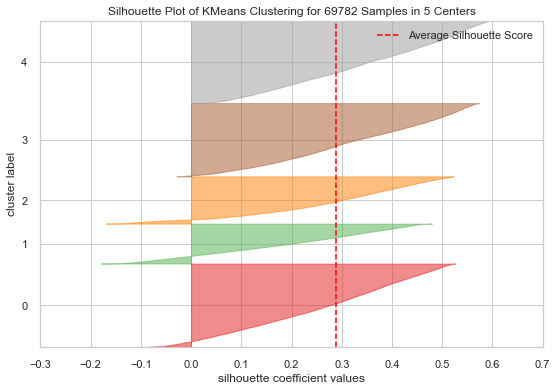

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 69782 Samples in 5 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [172]:
# Instantiate the clustering model and visualizer
model = KMeans(5)
visualizer = SilhouetteVisualizer(model)

visualizer.fit(X_F1)    # Fit the data to the visualizer
visualizer.poof()    # Draw/show/poof the data

In [173]:
print('Le silhouette score du modèle M0 est de',
      round(visualizer.silhouette_score_, 3))

Le silhouette score du modèle M0 est de 0.289


Pour regarder à quoi ressemble les clusters, j'utilise une ACP pour projeter les données sur 3 dimensions. J'utilise pour cela le module décomposition de scikit-learn.

In [174]:
pca = decomposition.PCA(n_components=2)
pca.fit(X_F1)
print(pca.explained_variance_ratio_.cumsum())
X_trans_F1 = pca.transform(X_F1)

[0.50176703 0.76339161]


J'ai affiché le pourcentage de variance expliquée par la première composante et par les deux premières composantes cumulées.

On a donc près de 76% de la variance totale qui sont expliquées par ces 2 premières composantes.

Il est donc possible d'utiliser ces deux premières composantes pour représenter les données.

J'affiche les données projetées selon ces deux dimensions, colorées selon le cluster auquel elles appartiennent, pour 5 clusters.

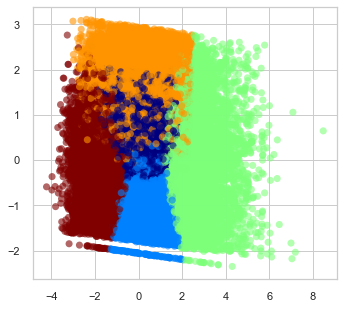

In [175]:
# je crée une figure
fig = plt.figure(figsize=(12, 5))

# Je détermine la clusterisation C0 des données F0 sur base du modèle M0
M1 = cluster.KMeans(n_clusters=5, random_state=42)
C1_new = M1.fit(X_F1)
ax = fig.add_subplot(122)
ax.scatter(X_trans_F1[:, 0], X_trans_F1[:, 1], c=M1.labels_,
           edgecolors="none", cmap="jet", alpha=0.6, s=50)

**Note :** La partie centrale de la population du graphe forme maintenant le cinquième cluster.

Comme cela se passerait dans la vie réelle, nous allons maintenant sauvegarder ce modèle **Kmeans à 5 clusters** entrainé sur les **données F0**, pour pouvoir l'utiliser plus tard et prédire les données à la partie suivante de l'analyse de la fréquence de maintenance.

Pour notre exercice, je me contenterai de **garder en mémoire vive le modèle M1**.

In [176]:
# save the model
dump(M1, open('kmeans_M1.pkl', 'wb'))

## 10.4 | Comparaison C1_new et C1_init

In [177]:
C1_init

array([2, 4, 2, ..., 0, 2, 2])

In [178]:
C1_new.labels_

array([1, 4, 1, ..., 0, 1, 1])

In [179]:
# Comparaison des deux clusterisations réalisées
print(metrics.adjusted_rand_score(C1_init, C1_new.labels_))

0.8048664240968666


In [180]:
results.loc[['M_4_mths'], ['ARI_T1']] = metrics.adjusted_rand_score(
    C1_init, C1_new.labels_)

Le score ARI mesure le degré de similitude entre deux clusterisations.
Plus il est proche de 1, plus les individus sont classés de la même manière.

Nous souhaitions mesurer un **ARI d'au moins 0.8** pour considérer les clusterisations similaires et donc la prédiction suffisamment précise pour être maintenue durant la période retenue (ici 3 mois), ce qui est le cas.

Nous pourrions donc **envisager une maintenance tous les 4 mois** de la clusterisation.

Vérifions toutefois si cette fréquence reste pertinente au vu de cet indicateur après un second cycle.

## 10.5 | Préparation fichier F2 et prédictions C2_M1 sur base de M1

### 10.5.1 | Préparation du fichier clients F2 - via la fonction fichier_clients()

J'ai défini une fonction **fichier_clients()** qui crée le fichier clients Fi à date Ti, à partir des divers fichiers sources, et pour les commandes passées jusqu’à la date Ti.

-  la variable d'entrée de cette fonction est la date Ti de la dernière commande.

-  la fonction réalise le filtrage des commandes jusqu’à la date Ti et crée les features.

-  la fonction retourne le jeu de données data par client unique sous la forme d'un dataframe.

In [181]:
date = '2018-08-31'

In [182]:
date = pd.to_datetime(date)

In [183]:
F2 = fichier_clients(date)

We removed 0 lines from the items dataframe.
We removed 775 lines from the orders dataframe.
We removed 775 lines from the payments dataframe.
On constate un écart total en valeur de -2726.93 Reais, soit -0.02 % entre les données de payments et celles de items.       
Je considère que cet écart est non significatif, nous pouvons donc exploiter les données
(99214, 25)
The dataframe data contains for the moment 95420 customer_unique_id.
We saw earlier that unique customers are identified by the feature customer_unique_id
Nous avons retiré 1 individu(s) sans payment_value retirés du jeu de données.
749 individu(s) sans review_score retirés du jeu de données.
Avant de filtrer sur la date demandée nous avons construit une base de données contenant 98464 commandes pour un CA de 15774881.4 Reais.


In [184]:
F2.last_purch.max() < date

True

In [185]:
print('Ce fichier client ne compte bien que les commandes passées avant',
      date, '\ndate de dernière commande la plus récente :', F2.last_purch.max())

Ce fichier client ne compte bien que les commandes passées avant 2018-08-31 00:00:00 
date de dernière commande la plus récente : 2018-08-29 15:00:37


### 10.5.2 | Standardisation des features de F2 (sur base du scaler de F1)

Here are the useful features selected for the model : 

In [186]:
useful_features = ['recency_log', 'aver_basket_log',
                   'monetary_log', 'satisfaction', 'nb_articles', 'nb_diff_products']

In [187]:
# Bring the data on same scale (using scaler_F1)
Scaled_Data_F2_base_F1 = scaler_F1.fit_transform(F2.loc[:, useful_features])

In [188]:
# Transform it back to dataframe
Scaled_Data_F2_base_F1 = pd.DataFrame(
    Scaled_Data_F2_base_F1, index=F2.index, columns=F2.loc[:, useful_features].columns)

In [189]:
Scaled_Data_RAMS_F2_base_F1 = Scaled_Data_F2_base_F1[[
    'recency_log', 'aver_basket_log', 'monetary_log', 'satisfaction']]

### 10.5.3 | Clusterisation C2_M1 | sur base du modèle M1

In [190]:
X_F2_base_F1 = Scaled_Data_RAMS_F2_base_F1.values

X_F2_base_F1 est déjà normalisé (avec Standard Scaler), nous n'avons donc pas besoin de réaliser cette étape à nouveau ici.

In [191]:
print(X_F2_base_F1.shape)

(94720, 4)


In [192]:
# Je détermine la clusterisation C1_init des données F1 sur base du modèle M0
C2_M1 = M1.predict(X_F2_base_F1)

In [193]:
C2_M1

array([0, 4, 1, ..., 1, 0, 1])

## 10.6 | Entrainement modèle M2 et clusterisation C2_new sur base de M2

### 10.6.1 | Standardisation des features de F2 (sur base du scaler de F2)

Here are the useful features selected for the model : 

In [194]:
useful_features = ['recency_log', 'aver_basket_log',
                   'monetary_log', 'satisfaction', 'nb_articles', 'nb_diff_products']

In [195]:
# Bring the data on same scale (using scaler_F0)
scaler_F2 = StandardScaler()
Scaled_Data_F2 = scaler_F2.fit_transform(F2.loc[:, useful_features])

In [196]:
# Transform it back to dataframe
Scaled_Data_F2 = pd.DataFrame(
    Scaled_Data_F2, index=F2.index, columns=F2.loc[:, useful_features].columns)

In [197]:
Scaled_Data_RAMS_F2 = Scaled_Data_F2[[
    'recency_log', 'aver_basket_log', 'monetary_log', 'satisfaction']]

### 10.6.2 | Modélisation Kmeans M2 | sur base des données F2

In [198]:
X_F2 = Scaled_Data_RAMS_F2.values

X_F2 est déjà normalisé (avec Standard Scaler), nous n'avons donc pas besoin de réaliser cette étape à nouveau ici.

In [199]:
print(X_F2.shape)

(94720, 4)


Je vais maintenant créer un clustering à l'aide du **modèle k-means**.<br>
Il contiendra comme identifié précédemment **5 clusters**, la taille cible.<br>
Je vais représenter les clusters et calculer un **coefficient de silhouette** pour pouvoir comparer l'évolution dans le temps.

In [200]:
mpl.rcParams["figure.figsize"] = (9, 6)

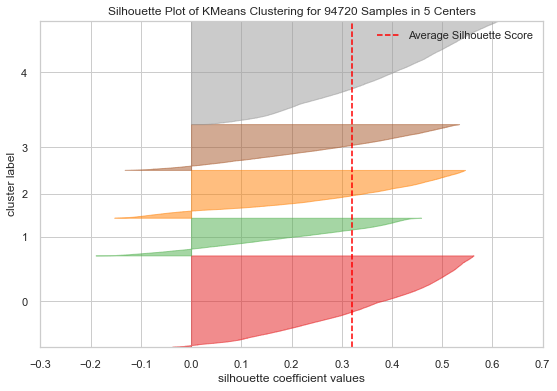

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 94720 Samples in 5 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [201]:
# Instantiate the clustering model and visualizer
model = KMeans(5)
visualizer = SilhouetteVisualizer(model)

visualizer.fit(X_F2)    # Fit the data to the visualizer
visualizer.poof()    # Draw/show/poof the data

In [202]:
print('Le silhouette score du modèle M0 est de',
      round(visualizer.silhouette_score_, 3))

Le silhouette score du modèle M0 est de 0.321


Pour regarder à quoi ressemble les clusters, j'utilise une ACP pour projeter les données sur 3 dimensions. J'utilise pour cela le module décomposition de scikit-learn.

In [203]:
pca = decomposition.PCA(n_components=2)
pca.fit(X_F2)
print(pca.explained_variance_ratio_.cumsum())
X_trans_F2 = pca.transform(X_F2)

[0.50158327 0.76192021]


J'ai affiché le pourcentage de variance expliquée par la première composante et par les deux premières composantes cumulées.

On a donc près de 76% de la variance totale qui sont expliquées par ces 2 premières composantes.

Il est donc possible d'utiliser ces deux premières composantes pour représenter les données.

J'affiche les données projetées selon ces deux dimensions, colorées selon le cluster auquel elles appartiennent, pour 5 clusters.

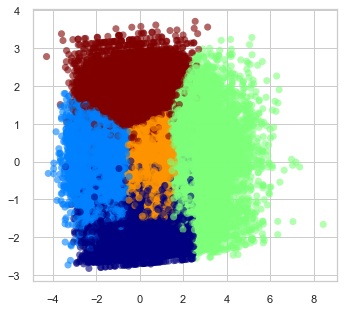

In [204]:
# je crée une figure
fig = plt.figure(figsize=(12, 5))

# Je détermine la clusterisation C0 des données F0 sur base du modèle M0
M2 = cluster.KMeans(n_clusters=5, random_state=42)
C2_new = M2.fit(X_F2)
ax = fig.add_subplot(122)
ax.scatter(X_trans_F2[:, 0], X_trans_F2[:, 1], c=M2.labels_,
           edgecolors="none", cmap="jet", alpha=0.6, s=50)

**Note :** La partie centrale de la population du graphe forme maintenant le cinquième cluster.

Comme cela se passerait dans la vie réelle, nous allons maintenant sauvegarder ce modèle **Kmeans à 5 clusters** entrainé sur les **données F0**, pour pouvoir l'utiliser plus tard et prédire les données à la partie suivante de l'analyse de la fréquence de maintenance.

Pour notre exercice, je me contenterai de **garder en mémoire vive le modèle M2**.

In [205]:
# save the model
dump(M2, open('kmeans_M2.pkl', 'wb'))

## 10.7 | Comparaison C2_new et C2_M1

In [206]:
C2_M1

array([0, 4, 1, ..., 1, 0, 1])

In [207]:
C2_new.labels_

array([3, 1, 0, ..., 3, 3, 1])

In [208]:
# Comparaison des deux clusterisations réalisées
print(metrics.adjusted_rand_score(C2_M1, C2_new.labels_))

0.7039485111271355


In [209]:
results.loc[['M_4_mths'], ['ARI_T2']
            ] = metrics.adjusted_rand_score(C2_M1, C2_new.labels_)

Le score ARI mesure le degré de similitude entre deux clusterisations.
Plus il est proche de 1, plus les individus sont classés de la même manière.

Nous souhaitions mesurer un **ARI d'au moins 0.8** pour considérer les clusterisations similaires et donc la prédiction suffisamment précise pour être maintenue durant la période retenue (ici 3 mois), ce qui est le cas.

Nous devons donc **reconsidérer la fréquence de maintenance tous les 4 mois** de la clusterisation.

# 11 | Fréquence maintenance = 3 mois

## 11.1 | Préparation fichier F0, entrainement modèle M0, clusterisation C0

### 11.1.1 | Préparation du fichier clients F0 - via la fonction fichier_clients()

J'ai défini une fonction **fichier_clients()** qui crée le fichier clients Fi à date Ti, à partir des divers fichiers sources, et pour les commandes passées jusqu’à la date Ti.

-  la variable d'entrée de cette fonction est la date Ti de la dernière commande.

-  la fonction réalise le filtrage des commandes jusqu’à la date Ti et crée les features.

-  la fonction retourne le jeu de données data par client unique sous la forme d'un dataframe.

In [210]:
date = '2018-02-28'

In [211]:
date = pd.to_datetime(date)

In [212]:
F0 = fichier_clients(date)

We removed 0 lines from the items dataframe.
We removed 775 lines from the orders dataframe.
We removed 775 lines from the payments dataframe.
On constate un écart total en valeur de -2726.93 Reais, soit -0.02 % entre les données de payments et celles de items.       
Je considère que cet écart est non significatif, nous pouvons donc exploiter les données
(99214, 25)
The dataframe data contains for the moment 95420 customer_unique_id.
We saw earlier that unique customers are identified by the feature customer_unique_id
Nous avons retiré 1 individu(s) sans payment_value retirés du jeu de données.
749 individu(s) sans review_score retirés du jeu de données.
Avant de filtrer sur la date demandée nous avons construit une base de données contenant 98464 commandes pour un CA de 15774881.4 Reais.


In [213]:
F0.last_purch.max() < date

True

In [214]:
print('Ce fichier client ne compte bien que les commandes passées avant',
      date, '\ndate de dernière commande la plus récente :', F0.last_purch.max())

Ce fichier client ne compte bien que les commandes passées avant 2018-02-28 00:00:00 
date de dernière commande la plus récente : 2018-02-27 23:59:53


### 11.1.2 | Standardisation des features de F0

Here are the useful features selected for the model : 

In [215]:
useful_features = ['recency_log', 'aver_basket_log',
                   'monetary_log', 'satisfaction', 'nb_articles', 'nb_diff_products']

In [216]:
# Bring the data on same scale
scaler_F0 = StandardScaler()
Scaled_Data_F0 = scaler_F0.fit_transform(F0.loc[:, useful_features])

In [217]:
# Transform it back to dataframe
Scaled_Data_F0 = pd.DataFrame(
    Scaled_Data_F0, index=F0.index, columns=F0.loc[:, useful_features].columns)

In [218]:
Scaled_Data_RAMS_F0 = Scaled_Data_F0[[
    'recency_log', 'aver_basket_log', 'monetary_log', 'satisfaction']]

J'exporte le scaler_F0 au format pickle pour la suite :
-  partant du principe qu'en situation réelle nous n'aurons pas forcément toutes les données à l'avance, il conviendra de procéder ainsi (stockage du scaler / modèle sur disque et restore pour comparaison).

-  pour le charger lorsque les données seront disponibles, on pourra effectuer le code suivant : 
scaler_F0 = load(open('scaler_F0.pkl', 'rb'))

-  mais dans notre cas étant donnée que toutes les données sont disponibles à l'instant t nous garderons en mémoire vive les différents scalers et modèles pour effectuer nos comparaisons. 

In [219]:
# save the scaler
dump(scaler_F0, open('scaler_F0.pkl', 'wb'))

### 11.1.3 | Modélisation Kmeans M0 | sur base des données F0

In [220]:
X_F0 = Scaled_Data_RAMS_F0.values

X_F0 est déjà normalisé (avec Standard Scaler), nous n'avons donc pas besoin de réaliser cette étape à nouveau ici.

In [221]:
print(X_F0.shape)

(56161, 4)


Je vais maintenant créer un clustering à l'aide du **modèle k-means**.<br>
Il contiendra comme identifié précédemment **5 clusters**, la taille cible.<br>
Je vais représenter les clusters et calculer un **coefficient de silhouette** pour pouvoir comparer l'évolution dans le temps.

In [222]:
mpl.rcParams["figure.figsize"] = (9, 6)

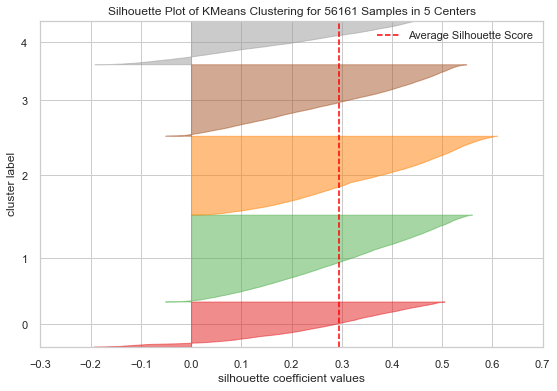

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 56161 Samples in 5 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [223]:
# Instantiate the clustering model and visualizer
model = KMeans(5)
visualizer = SilhouetteVisualizer(model)

visualizer.fit(X_F0)    # Fit the data to the visualizer
visualizer.poof()    # Draw/show/poof the data

In [224]:
print('Le silhouette score du modèle M0 est de',
      round(visualizer.silhouette_score_, 3))

Le silhouette score du modèle M0 est de 0.294


Pour regarder à quoi ressemble les clusters, j'utilise une ACP pour projeter les données sur 3 dimensions. J'utilise pour cela le module décomposition de scikit-learn.

In [225]:
pca = decomposition.PCA(n_components=2)
pca.fit(X_F0)
print(pca.explained_variance_ratio_.cumsum())
X_trans_F0 = pca.transform(X_F0)

[0.50148741 0.76455366]


J'ai affiché le pourcentage de variance expliquée par la première composante et par les deux premières composantes cumulées.

On a donc près de 76% de la variance totale qui sont expliquées par ces 2 premières composantes.

Il est donc possible d'utiliser ces deux premières composantes pour représenter les données.

J'affiche les données projetées selon ces deux dimensions, colorées selon le cluster auquel elles appartiennent, pour 5 clusters.

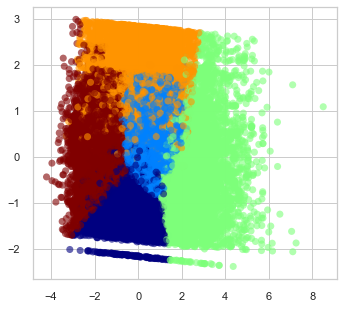

In [226]:
# je crée une figure
fig = plt.figure(figsize=(12, 5))

# Je détermine la clusterisation C0 des données F0 sur base du modèle M0
M0 = cluster.KMeans(n_clusters=5, random_state=42)
C0 = M0.fit(X_F0)
ax = fig.add_subplot(122)
ax.scatter(X_trans_F0[:, 0], X_trans_F0[:, 1], c=M0.labels_,
           edgecolors="none", cmap="jet", alpha=0.6, s=50)

**Note :** La partie centrale de la population du graphe forme maintenant le cinquième cluster.

Comme cela se passerait dans la vie réelle, nous allons maintenant sauvegarder ce modèle **Kmeans à 5 clusters** entrainé sur les **données F0**, pour pouvoir l'utiliser plus tard et prédire les données à la partie suivante de l'analyse de la fréquence de maintenance.

Pour notre exercice, je me contenterai de **garder en mémoire vive le modèle M0**.

In [227]:
# save the model
dump(M0, open('kmeans_M0.pkl', 'wb'))

## 11.2 | Préparation fichier F1 et prédictions C1_init sur base de M0

### 11.2.1 | Préparation du fichier clients F1 - via la fonction fichier_clients()

J'ai défini une fonction **fichier_clients()** qui crée le fichier clients Fi à date Ti, à partir des divers fichiers sources, et pour les commandes passées jusqu’à la date Ti.

-  la variable d'entrée de cette fonction est la date Ti de la dernière commande.

-  la fonction réalise le filtrage des commandes jusqu’à la date Ti et crée les features.

-  la fonction retourne le jeu de données data par client unique sous la forme d'un dataframe.

In [228]:
date = '2018-05-31'

In [229]:
date = pd.to_datetime(date)

In [230]:
F1 = fichier_clients(date)

We removed 0 lines from the items dataframe.
We removed 775 lines from the orders dataframe.
We removed 775 lines from the payments dataframe.
On constate un écart total en valeur de -2726.93 Reais, soit -0.02 % entre les données de payments et celles de items.       
Je considère que cet écart est non significatif, nous pouvons donc exploiter les données
(99214, 25)
The dataframe data contains for the moment 95420 customer_unique_id.
We saw earlier that unique customers are identified by the feature customer_unique_id
Nous avons retiré 1 individu(s) sans payment_value retirés du jeu de données.
749 individu(s) sans review_score retirés du jeu de données.
Avant de filtrer sur la date demandée nous avons construit une base de données contenant 98464 commandes pour un CA de 15774881.4 Reais.


In [231]:
F1.last_purch.max() < date

True

In [232]:
print('Ce fichier client ne compte bien que les commandes passées avant',
      date, '\ndate de dernière commande la plus récente :', F1.last_purch.max())

Ce fichier client ne compte bien que les commandes passées avant 2018-05-31 00:00:00 
date de dernière commande la plus récente : 2018-05-30 23:59:35


### 11.2.2 | Standardisation des features de F1 (sur base du scaler de F0)

Here are the useful features selected for the model : 

In [233]:
useful_features = ['recency_log', 'aver_basket_log',
                   'monetary_log', 'satisfaction', 'nb_articles', 'nb_diff_products']

In [234]:
# Bring the data on same scale (using scaler_F0)
scaler_F0 = load(open('scaler_F0.pkl', 'rb'))
Scaled_Data_F1_base_F0 = scaler_F0.fit_transform(F1.loc[:, useful_features])

In [235]:
# Transform it back to dataframe
Scaled_Data_F1_base_F0 = pd.DataFrame(
    Scaled_Data_F1_base_F0, index=F1.index, columns=F1.loc[:, useful_features].columns)

In [236]:
Scaled_Data_RAMS_F1_base_F0 = Scaled_Data_F1_base_F0[[
    'recency_log', 'aver_basket_log', 'monetary_log', 'satisfaction']]

### 11.2.3 | Clusterisation C1_init | sur base du modèle M0

In [237]:
X_F1_base_F0 = Scaled_Data_RAMS_F1_base_F0.values

X_F1_base_F0 est déjà normalisé (avec Standard Scaler), nous n'avons donc pas besoin de réaliser cette étape à nouveau ici.

In [238]:
print(X_F1_base_F0.shape)

(76455, 4)


In [239]:
# Je détermine la clusterisation C1_init des données F1 sur base du modèle M0
C1_init = M0.predict(X_F1_base_F0)

In [240]:
C1_init

array([1, 4, 0, ..., 0, 1, 0])

## 11.3 | Entrainement modèle M1 et clusterisation C1_new sur base de M1

### 11.3.1 | Standardisation des features de F1 (sur base du scaler de F1)

Here are the useful features selected for the model : 

In [241]:
useful_features = ['recency_log', 'aver_basket_log',
                   'monetary_log', 'satisfaction', 'nb_articles', 'nb_diff_products']

In [242]:
# Bring the data on same scale (using scaler_F0)
scaler_F1 = StandardScaler()
Scaled_Data_F1 = scaler_F1.fit_transform(F1.loc[:, useful_features])

In [243]:
# Transform it back to dataframe
Scaled_Data_F1 = pd.DataFrame(
    Scaled_Data_F1, index=F1.index, columns=F1.loc[:, useful_features].columns)

In [244]:
Scaled_Data_RAMS_F1 = Scaled_Data_F1[[
    'recency_log', 'aver_basket_log', 'monetary_log', 'satisfaction']]

### 11.3.2 | Modélisation Kmeans M1 | sur base des données F1

In [245]:
X_F1 = Scaled_Data_RAMS_F1.values

X_F1 est déjà normalisé (avec Standard Scaler), nous n'avons donc pas besoin de réaliser cette étape à nouveau ici.

In [246]:
print(X_F1.shape)

(76455, 4)


Je vais maintenant créer un clustering à l'aide du **modèle k-means**.<br>
Il contiendra comme identifié précédemment **5 clusters**, la taille cible.<br>
Je vais représenter les clusters et calculer un **coefficient de silhouette** pour pouvoir comparer l'évolution dans le temps.

In [247]:
mpl.rcParams["figure.figsize"] = (9, 6)

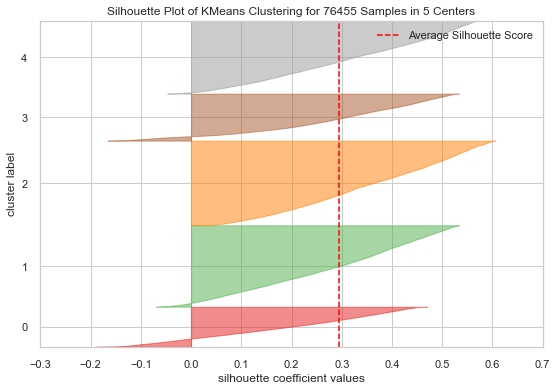

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 76455 Samples in 5 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [248]:
# Instantiate the clustering model and visualizer
model = KMeans(5)
visualizer = SilhouetteVisualizer(model)

visualizer.fit(X_F1)    # Fit the data to the visualizer
visualizer.poof()    # Draw/show/poof the data

In [249]:
print('Le silhouette score du modèle M0 est de',
      round(visualizer.silhouette_score_, 3))

Le silhouette score du modèle M0 est de 0.295


Pour regarder à quoi ressemble les clusters, j'utilise une ACP pour projeter les données sur 3 dimensions. J'utilise pour cela le module décomposition de scikit-learn.

In [250]:
pca = decomposition.PCA(n_components=2)
pca.fit(X_F1)
print(pca.explained_variance_ratio_.cumsum())
X_trans_F1 = pca.transform(X_F1)

[0.50182697 0.75642838]


J'ai affiché le pourcentage de variance expliquée par la première composante et par les deux premières composantes cumulées.

On a donc près de 76% de la variance totale qui sont expliquées par ces 2 premières composantes.

Il est donc possible d'utiliser ces deux premières composantes pour représenter les données.

J'affiche les données projetées selon ces deux dimensions, colorées selon le cluster auquel elles appartiennent, pour 5 clusters.

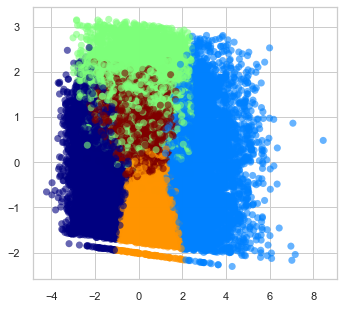

In [251]:
# je crée une figure
fig = plt.figure(figsize=(12, 5))

# Je détermine la clusterisation C0 des données F0 sur base du modèle M0
M1 = cluster.KMeans(n_clusters=5, random_state=42)
C1_new = M1.fit(X_F1)
ax = fig.add_subplot(122)
ax.scatter(X_trans_F1[:, 0], X_trans_F1[:, 1], c=M1.labels_,
           edgecolors="none", cmap="jet", alpha=0.6, s=50)

**Note :** La partie centrale de la population du graphe forme maintenant le cinquième cluster.

Comme cela se passerait dans la vie réelle, nous allons maintenant sauvegarder ce modèle **Kmeans à 5 clusters** entrainé sur les **données F0**, pour pouvoir l'utiliser plus tard et prédire les données à la partie suivante de l'analyse de la fréquence de maintenance.

Pour notre exercice, je me contenterai de **garder en mémoire vive le modèle M1**.

In [252]:
# save the model
dump(M1, open('kmeans_M1.pkl', 'wb'))

## 11.4 | Comparaison C1_new et C1_init

In [253]:
C1_init

array([1, 4, 0, ..., 0, 1, 0])

In [254]:
C1_new.labels_

array([4, 0, 3, ..., 3, 4, 0])

In [255]:
# Comparaison des deux clusterisations réalisées
print(metrics.adjusted_rand_score(C1_init, C1_new.labels_))

0.4848314546877098


In [256]:
results.loc[['M_3_mths'], ['ARI_T1']] = metrics.adjusted_rand_score(
    C1_init, C1_new.labels_)

Le score ARI mesure le degré de similitude entre deux clusterisations.
Plus il est proche de 1, plus les individus sont classés de la même manière.

Nous souhaitions mesurer un **ARI d'au moins 0.8** pour considérer les clusterisations similaires et donc la prédiction suffisamment précise pour être maintenue durant la période retenue (ici 3 mois), ce qui est le cas.

Nous ne pouvons donc **pas préconiser une maintenance tous les 3 mois** de la clusterisation.

## 11.5 | Préparation fichier F2 et prédictions C2_M1 sur base de M1

### 11.5.1 | Préparation du fichier clients F2 - via la fonction fichier_clients()

J'ai défini une fonction **fichier_clients()** qui crée le fichier clients Fi à date Ti, à partir des divers fichiers sources, et pour les commandes passées jusqu’à la date Ti.

-  la variable d'entrée de cette fonction est la date Ti de la dernière commande.

-  la fonction réalise le filtrage des commandes jusqu’à la date Ti et crée les features.

-  la fonction retourne le jeu de données data par client unique sous la forme d'un dataframe.

In [257]:
date = '2018-08-31'

In [258]:
date = pd.to_datetime(date)

In [259]:
F2 = fichier_clients(date)

We removed 0 lines from the items dataframe.
We removed 775 lines from the orders dataframe.
We removed 775 lines from the payments dataframe.
On constate un écart total en valeur de -2726.93 Reais, soit -0.02 % entre les données de payments et celles de items.       
Je considère que cet écart est non significatif, nous pouvons donc exploiter les données
(99214, 25)
The dataframe data contains for the moment 95420 customer_unique_id.
We saw earlier that unique customers are identified by the feature customer_unique_id
Nous avons retiré 1 individu(s) sans payment_value retirés du jeu de données.
749 individu(s) sans review_score retirés du jeu de données.
Avant de filtrer sur la date demandée nous avons construit une base de données contenant 98464 commandes pour un CA de 15774881.4 Reais.


In [260]:
F2.last_purch.max() < date

True

In [261]:
print('Ce fichier client ne compte bien que les commandes passées avant',
      date, '\ndate de dernière commande la plus récente :', F2.last_purch.max())

Ce fichier client ne compte bien que les commandes passées avant 2018-08-31 00:00:00 
date de dernière commande la plus récente : 2018-08-29 15:00:37


### 11.5.2 | Standardisation des features de F2 (sur base du scaler de F1)

Here are the useful features selected for the model : 

In [262]:
useful_features = ['recency_log', 'aver_basket_log',
                   'monetary_log', 'satisfaction', 'nb_articles', 'nb_diff_products']

In [263]:
# Bring the data on same scale (using scaler_F1)
Scaled_Data_F2_base_F1 = scaler_F1.fit_transform(F2.loc[:, useful_features])

In [264]:
# Transform it back to dataframe
Scaled_Data_F2_base_F1 = pd.DataFrame(
    Scaled_Data_F2_base_F1, index=F2.index, columns=F2.loc[:, useful_features].columns)

In [265]:
Scaled_Data_RAMS_F2_base_F1 = Scaled_Data_F2_base_F1[[
    'recency_log', 'aver_basket_log', 'monetary_log', 'satisfaction']]

### 11.5.3 | Clusterisation C2_M1 | sur base du modèle M1

In [266]:
X_F2_base_F1 = Scaled_Data_RAMS_F2_base_F1.values

X_F2_base_F1 est déjà normalisé (avec Standard Scaler), nous n'avons donc pas besoin de réaliser cette étape à nouveau ici.

In [267]:
print(X_F2_base_F1.shape)

(94720, 4)


In [268]:
# Je détermine la clusterisation C1_init des données F1 sur base du modèle M0
C2_M1 = M1.predict(X_F2_base_F1)

In [269]:
C2_M1

array([4, 0, 3, ..., 3, 4, 0])

## 11.6 | Entrainement modèle M2 et clusterisation C2_new sur base de M2

### 11.6.1 | Standardisation des features de F2 (sur base du scaler de F2)

Here are the useful features selected for the model : 

In [270]:
useful_features = ['recency_log', 'aver_basket_log',
                   'monetary_log', 'satisfaction', 'nb_articles', 'nb_diff_products']

In [271]:
# Bring the data on same scale (using scaler_F0)
scaler_F2 = StandardScaler()
Scaled_Data_F2 = scaler_F2.fit_transform(F2.loc[:, useful_features])

In [272]:
# Transform it back to dataframe
Scaled_Data_F2 = pd.DataFrame(
    Scaled_Data_F2, index=F2.index, columns=F2.loc[:, useful_features].columns)

In [273]:
Scaled_Data_RAMS_F2 = Scaled_Data_F2[[
    'recency_log', 'aver_basket_log', 'monetary_log', 'satisfaction']]

### 11.6.2 | Modélisation Kmeans M2 | sur base des données F2

In [274]:
X_F2 = Scaled_Data_RAMS_F2.values

X_F2 est déjà normalisé (avec Standard Scaler), nous n'avons donc pas besoin de réaliser cette étape à nouveau ici.

In [275]:
print(X_F2.shape)

(94720, 4)


Je vais maintenant créer un clustering à l'aide du **modèle k-means**.<br>
Il contiendra comme identifié précédemment **5 clusters**, la taille cible.<br>
Je vais représenter les clusters et calculer un **coefficient de silhouette** pour pouvoir comparer l'évolution dans le temps.

In [276]:
mpl.rcParams["figure.figsize"] = (9, 6)

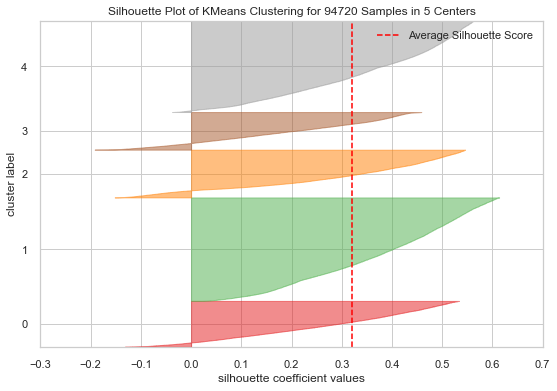

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 94720 Samples in 5 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [277]:
# Instantiate the clustering model and visualizer
model = KMeans(5)
visualizer = SilhouetteVisualizer(model)

visualizer.fit(X_F2)    # Fit the data to the visualizer
visualizer.poof()    # Draw/show/poof the data

In [278]:
print('Le silhouette score du modèle M0 est de',
      round(visualizer.silhouette_score_, 3))

Le silhouette score du modèle M0 est de 0.321


Pour regarder à quoi ressemble les clusters, j'utilise une ACP pour projeter les données sur 3 dimensions. J'utilise pour cela le module décomposition de scikit-learn.

In [279]:
pca = decomposition.PCA(n_components=2)
pca.fit(X_F2)
print(pca.explained_variance_ratio_.cumsum())
X_trans_F2 = pca.transform(X_F2)

[0.50158327 0.76192021]


J'ai affiché le pourcentage de variance expliquée par la première composante et par les deux premières composantes cumulées.

On a donc près de 76% de la variance totale qui sont expliquées par ces 2 premières composantes.

Il est donc possible d'utiliser ces deux premières composantes pour représenter les données.

J'affiche les données projetées selon ces deux dimensions, colorées selon le cluster auquel elles appartiennent, pour 5 clusters.

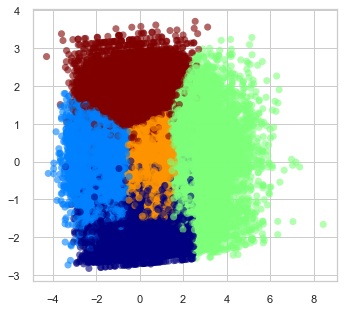

In [280]:
# je crée une figure
fig = plt.figure(figsize=(12, 5))

# Je détermine la clusterisation C0 des données F0 sur base du modèle M0
M2 = cluster.KMeans(n_clusters=5, random_state=42)
C2_new = M2.fit(X_F2)
ax = fig.add_subplot(122)
ax.scatter(X_trans_F2[:, 0], X_trans_F2[:, 1], c=M2.labels_,
           edgecolors="none", cmap="jet", alpha=0.6, s=50)

**Note :** La partie centrale de la population du graphe forme maintenant le cinquième cluster.

Comme cela se passerait dans la vie réelle, nous allons maintenant sauvegarder ce modèle **Kmeans à 5 clusters** entrainé sur les **données F0**, pour pouvoir l'utiliser plus tard et prédire les données à la partie suivante de l'analyse de la fréquence de maintenance.

Pour notre exercice, je me contenterai de **garder en mémoire vive le modèle M2**.

In [281]:
# save the model
dump(M2, open('kmeans_M2.pkl', 'wb'))

## 11.7 | Comparaison C2_new et C2_M1

In [282]:
C2_M1

array([4, 0, 3, ..., 3, 4, 0])

In [283]:
C2_new.labels_

array([3, 1, 0, ..., 3, 3, 1])

In [284]:
# Comparaison des deux clusterisations réalisées
print(metrics.adjusted_rand_score(C2_M1, C2_new.labels_))

0.7695366824975849


In [285]:
results.loc[['M_3_mths'], ['ARI_T2']
            ] = metrics.adjusted_rand_score(C2_M1, C2_new.labels_)

Le score ARI mesure le degré de similitude entre deux clusterisations.
Plus il est proche de 1, plus les individus sont classés de la même manière.

Nous souhaitions mesurer un **ARI d'au moins 0.8** pour considérer les clusterisations similaires et donc la prédiction suffisamment précise pour être maintenue durant la période retenue (ici 3 mois), ce qui est le cas.

Nous devons donc **reconsidérer la fréquence de maintenance tous les 3 mois** de la clusterisation.

# 12 | Fréquence maintenance = 2 mois

## 12.1 | Préparation fichier F0, entrainement modèle M0, clusterisation C0

### 12.1.1 | Préparation du fichier clients F0 - via la fonction fichier_clients()

J'ai défini une fonction **fichier_clients()** qui crée le fichier clients Fi à date Ti, à partir des divers fichiers sources, et pour les commandes passées jusqu’à la date Ti.

-  la variable d'entrée de cette fonction est la date Ti de la dernière commande.

-  la fonction réalise le filtrage des commandes jusqu’à la date Ti et crée les features.

-  la fonction retourne le jeu de données data par client unique sous la forme d'un dataframe.

In [286]:
date = '2018-04-30'

In [287]:
date = pd.to_datetime(date)

In [288]:
F0 = fichier_clients(date)

We removed 0 lines from the items dataframe.
We removed 775 lines from the orders dataframe.
We removed 775 lines from the payments dataframe.
On constate un écart total en valeur de -2726.93 Reais, soit -0.02 % entre les données de payments et celles de items.       
Je considère que cet écart est non significatif, nous pouvons donc exploiter les données
(99214, 25)
The dataframe data contains for the moment 95420 customer_unique_id.
We saw earlier that unique customers are identified by the feature customer_unique_id
Nous avons retiré 1 individu(s) sans payment_value retirés du jeu de données.
749 individu(s) sans review_score retirés du jeu de données.
Avant de filtrer sur la date demandée nous avons construit une base de données contenant 98464 commandes pour un CA de 15774881.4 Reais.


In [289]:
F0.last_purch.max() < date

True

In [290]:
print('Ce fichier client ne compte bien que les commandes passées avant',
      date, '\ndate de dernière commande la plus récente :', F0.last_purch.max())

Ce fichier client ne compte bien que les commandes passées avant 2018-04-30 00:00:00 
date de dernière commande la plus récente : 2018-04-29 23:57:11


### 12.1.2 | Standardisation des features de F0

Here are the useful features selected for the model : 

In [291]:
useful_features = ['recency_log', 'aver_basket_log',
                   'monetary_log', 'satisfaction', 'nb_articles', 'nb_diff_products']

In [292]:
# Bring the data on same scale
scaler_F0 = StandardScaler()
Scaled_Data_F0 = scaler_F0.fit_transform(F0.loc[:, useful_features])

In [293]:
# Transform it back to dataframe
Scaled_Data_F0 = pd.DataFrame(
    Scaled_Data_F0, index=F0.index, columns=F0.loc[:, useful_features].columns)

In [294]:
Scaled_Data_RAMS_F0 = Scaled_Data_F0[[
    'recency_log', 'aver_basket_log', 'monetary_log', 'satisfaction']]

J'exporte le scaler_F0 au format pickle pour la suite :
-  partant du principe qu'en situation réelle nous n'aurons pas forcément toutes les données à l'avance, il conviendra de procéder ainsi (stockage du scaler / modèle sur disque et restore pour comparaison).

-  pour le charger lorsque les données seront disponibles, on pourra effectuer le code suivant : 
scaler_F0 = load(open('scaler_F0.pkl', 'rb'))

-  mais dans notre cas étant donnée que toutes les données sont disponibles à l'instant t nous garderons en mémoire vive les différents scalers et modèles pour effectuer nos comparaisons. 

In [295]:
# save the scaler
dump(scaler_F0, open('scaler_F0.pkl', 'wb'))

### 12.1.3 | Modélisation Kmeans M0 | sur base des données F0

In [296]:
X_F0 = Scaled_Data_RAMS_F0.values

X_F0 est déjà normalisé (avec Standard Scaler), nous n'avons donc pas besoin de réaliser cette étape à nouveau ici.

In [297]:
print(X_F0.shape)

(69782, 4)


Je vais maintenant créer un clustering à l'aide du **modèle k-means**.<br>
Il contiendra comme identifié précédemment **5 clusters**, la taille cible.<br>
Je vais représenter les clusters et calculer un **coefficient de silhouette** pour pouvoir comparer l'évolution dans le temps.

In [298]:
mpl.rcParams["figure.figsize"] = (9, 6)

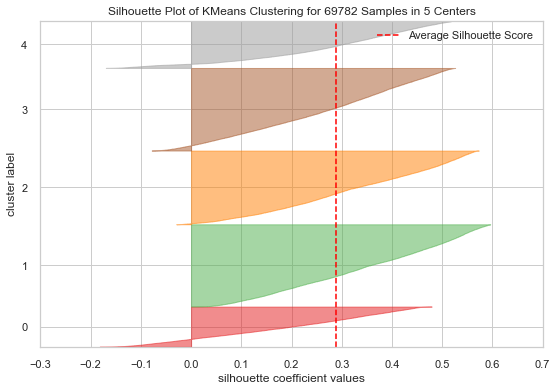

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 69782 Samples in 5 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [299]:
# Instantiate the clustering model and visualizer
model = KMeans(5)
visualizer = SilhouetteVisualizer(model)

visualizer.fit(X_F0)    # Fit the data to the visualizer
visualizer.poof()    # Draw/show/poof the data

In [300]:
print('Le silhouette score du modèle M0 est de',
      round(visualizer.silhouette_score_, 3))

Le silhouette score du modèle M0 est de 0.289


Pour regarder à quoi ressemble les clusters, j'utilise une ACP pour projeter les données sur 3 dimensions. J'utilise pour cela le module décomposition de scikit-learn.

In [301]:
pca = decomposition.PCA(n_components=2)
pca.fit(X_F0)
print(pca.explained_variance_ratio_.cumsum())
X_trans_F0 = pca.transform(X_F0)

[0.50176703 0.76339161]


J'ai affiché le pourcentage de variance expliquée par la première composante et par les deux premières composantes cumulées.

On a donc près de 76% de la variance totale qui sont expliquées par ces 2 premières composantes.

Il est donc possible d'utiliser ces deux premières composantes pour représenter les données.

J'affiche les données projetées selon ces deux dimensions, colorées selon le cluster auquel elles appartiennent, pour 5 clusters.

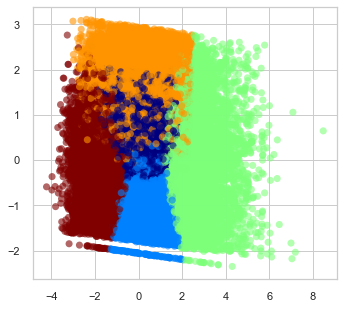

In [302]:
# je crée une figure
fig = plt.figure(figsize=(12, 5))

# Je détermine la clusterisation C0 des données F0 sur base du modèle M0
M0 = cluster.KMeans(n_clusters=5, random_state=42)
C0 = M0.fit(X_F0)
ax = fig.add_subplot(122)
ax.scatter(X_trans_F0[:, 0], X_trans_F0[:, 1], c=M0.labels_,
           edgecolors="none", cmap="jet", alpha=0.6, s=50)

**Note :** La partie centrale de la population du graphe forme maintenant le cinquième cluster.

Comme cela se passerait dans la vie réelle, nous allons maintenant sauvegarder ce modèle **Kmeans à 5 clusters** entrainé sur les **données F0**, pour pouvoir l'utiliser plus tard et prédire les données à la partie suivante de l'analyse de la fréquence de maintenance.

Pour notre exercice, je me contenterai de **garder en mémoire vive le modèle M0**.

In [303]:
# save the model
dump(M0, open('kmeans_M0.pkl', 'wb'))

## 12.2 | Préparation fichier F1 et prédictions C1_init sur base de M0

### 12.2.1 | Préparation du fichier clients F1 - via la fonction fichier_clients()

J'ai défini une fonction **fichier_clients()** qui crée le fichier clients Fi à date Ti, à partir des divers fichiers sources, et pour les commandes passées jusqu’à la date Ti.

-  la variable d'entrée de cette fonction est la date Ti de la dernière commande.

-  la fonction réalise le filtrage des commandes jusqu’à la date Ti et crée les features.

-  la fonction retourne le jeu de données data par client unique sous la forme d'un dataframe.

In [304]:
date = '2018-06-30'

In [305]:
date = pd.to_datetime(date)

In [306]:
F1 = fichier_clients(date)

We removed 0 lines from the items dataframe.
We removed 775 lines from the orders dataframe.
We removed 775 lines from the payments dataframe.
On constate un écart total en valeur de -2726.93 Reais, soit -0.02 % entre les données de payments et celles de items.       
Je considère que cet écart est non significatif, nous pouvons donc exploiter les données
(99214, 25)
The dataframe data contains for the moment 95420 customer_unique_id.
We saw earlier that unique customers are identified by the feature customer_unique_id
Nous avons retiré 1 individu(s) sans payment_value retirés du jeu de données.
749 individu(s) sans review_score retirés du jeu de données.
Avant de filtrer sur la date demandée nous avons construit une base de données contenant 98464 commandes pour un CA de 15774881.4 Reais.


In [307]:
F1.last_purch.max() < date

True

In [308]:
print('Ce fichier client ne compte bien que les commandes passées avant',
      date, '\ndate de dernière commande la plus récente :', F1.last_purch.max())

Ce fichier client ne compte bien que les commandes passées avant 2018-06-30 00:00:00 
date de dernière commande la plus récente : 2018-06-29 23:30:20


### 12.2.2 | Standardisation des features de F1 (sur base du scaler de F0)

Here are the useful features selected for the model : 

In [309]:
useful_features = ['recency_log', 'aver_basket_log',
                   'monetary_log', 'satisfaction', 'nb_articles', 'nb_diff_products']

In [310]:
# Bring the data on same scale (using scaler_F0)
scaler_F0 = load(open('scaler_F0.pkl', 'rb'))
Scaled_Data_F1_base_F0 = scaler_F0.fit_transform(F1.loc[:, useful_features])

In [311]:
# Transform it back to dataframe
Scaled_Data_F1_base_F0 = pd.DataFrame(
    Scaled_Data_F1_base_F0, index=F1.index, columns=F1.loc[:, useful_features].columns)

In [312]:
Scaled_Data_RAMS_F1_base_F0 = Scaled_Data_F1_base_F0[[
    'recency_log', 'aver_basket_log', 'monetary_log', 'satisfaction']]

### 12.2.3 | Clusterisation C1_init | sur base du modèle M0

In [313]:
X_F1_base_F0 = Scaled_Data_RAMS_F1_base_F0.values

X_F1_base_F0 est déjà normalisé (avec Standard Scaler), nous n'avons donc pas besoin de réaliser cette étape à nouveau ici.

In [314]:
print(X_F1_base_F0.shape)

(82373, 4)


In [315]:
# Je détermine la clusterisation C1_init des données F1 sur base du modèle M0
C1_init = M0.predict(X_F1_base_F0)

In [316]:
C1_init

array([0, 4, 1, ..., 1, 0, 1])

## 12.3 | Entrainement modèle M1 et clusterisation C1_new sur base de M1

### 12.3.1 | Standardisation des features de F1 (sur base du scaler de F1)

Here are the useful features selected for the model : 

In [317]:
useful_features = ['recency_log', 'aver_basket_log',
                   'monetary_log', 'satisfaction', 'nb_articles', 'nb_diff_products']

In [318]:
# Bring the data on same scale (using scaler_F0)
scaler_F1 = StandardScaler()
Scaled_Data_F1 = scaler_F1.fit_transform(F1.loc[:, useful_features])

In [319]:
# Transform it back to dataframe
Scaled_Data_F1 = pd.DataFrame(
    Scaled_Data_F1, index=F1.index, columns=F1.loc[:, useful_features].columns)

In [320]:
Scaled_Data_RAMS_F1 = Scaled_Data_F1[[
    'recency_log', 'aver_basket_log', 'monetary_log', 'satisfaction']]

### 12.3.2 | Modélisation Kmeans M1 | sur base des données F1

In [321]:
X_F1 = Scaled_Data_RAMS_F1.values

X_F1 est déjà normalisé (avec Standard Scaler), nous n'avons donc pas besoin de réaliser cette étape à nouveau ici.

In [322]:
print(X_F1.shape)

(82373, 4)


Je vais maintenant créer un clustering à l'aide du **modèle k-means**.<br>
Il contiendra comme identifié précédemment **5 clusters**, la taille cible.<br>
Je vais représenter les clusters et calculer un **coefficient de silhouette** pour pouvoir comparer l'évolution dans le temps.

In [323]:
mpl.rcParams["figure.figsize"] = (9, 6)

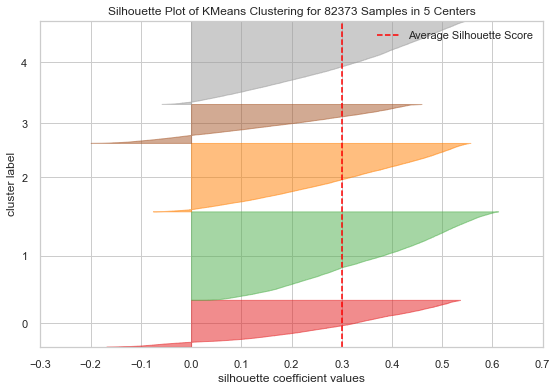

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 82373 Samples in 5 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [324]:
# Instantiate the clustering model and visualizer
model = KMeans(5)
visualizer = SilhouetteVisualizer(model)

visualizer.fit(X_F1)    # Fit the data to the visualizer
visualizer.poof()    # Draw/show/poof the data

In [325]:
print('Le silhouette score du modèle M0 est de',
      round(visualizer.silhouette_score_, 3))

Le silhouette score du modèle M0 est de 0.301


Pour regarder à quoi ressemble les clusters, j'utilise une ACP pour projeter les données sur 3 dimensions. J'utilise pour cela le module décomposition de scikit-learn.

In [326]:
pca = decomposition.PCA(n_components=2)
pca.fit(X_F1)
print(pca.explained_variance_ratio_.cumsum())
X_trans_F1 = pca.transform(X_F1)

[0.50184695 0.75290292]


J'ai affiché le pourcentage de variance expliquée par la première composante et par les deux premières composantes cumulées.

On a donc près de 76% de la variance totale qui sont expliquées par ces 2 premières composantes.

Il est donc possible d'utiliser ces deux premières composantes pour représenter les données.

J'affiche les données projetées selon ces deux dimensions, colorées selon le cluster auquel elles appartiennent, pour 5 clusters.

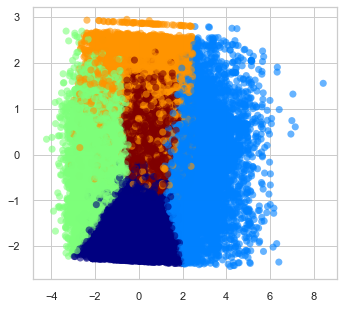

In [327]:
# je crée une figure
fig = plt.figure(figsize=(12, 5))

# Je détermine la clusterisation C0 des données F0 sur base du modèle M0
M1 = cluster.KMeans(n_clusters=5, random_state=42)
C1_new = M1.fit(X_F1)
ax = fig.add_subplot(122)
ax.scatter(X_trans_F1[:, 0], X_trans_F1[:, 1], c=M1.labels_,
           edgecolors="none", cmap="jet", alpha=0.6, s=50)

**Note :** La partie centrale de la population du graphe forme maintenant le cinquième cluster.

Comme cela se passerait dans la vie réelle, nous allons maintenant sauvegarder ce modèle **Kmeans à 5 clusters** entrainé sur les **données F0**, pour pouvoir l'utiliser plus tard et prédire les données à la partie suivante de l'analyse de la fréquence de maintenance.

Pour notre exercice, je me contenterai de **garder en mémoire vive le modèle M1**.

In [328]:
# save the model
dump(M1, open('kmeans_M1.pkl', 'wb'))

## 12.4 | Comparaison C1_new et C1_init

In [329]:
C1_init

array([0, 4, 1, ..., 1, 0, 1])

In [330]:
C1_new.labels_

array([0, 2, 4, ..., 4, 0, 2])

In [331]:
# Comparaison des deux clusterisations réalisées
print(metrics.adjusted_rand_score(C1_init, C1_new.labels_))

0.8250918645580647


In [332]:
results.loc[['M_2_mths'], ['ARI_T1']] = metrics.adjusted_rand_score(
    C1_init, C1_new.labels_)

Le score ARI mesure le degré de similitude entre deux clusterisations.
Plus il est proche de 1, plus les individus sont classés de la même manière.

Nous souhaitions mesurer un **ARI d'au moins 0.8** pour considérer les clusterisations similaires et donc la prédiction suffisamment précise pour être maintenue durant la période retenue (ici 3 mois), ce qui est le cas.

Nous pouvons donc **préconiser une maintenance tous les 4 mois** de la clusterisation.

## 12.5 | Préparation fichier F2 et prédictions C2_M1 sur base de M1

### 12.5.1 | Préparation du fichier clients F2 - via la fonction fichier_clients()

J'ai défini une fonction **fichier_clients()** qui crée le fichier clients Fi à date Ti, à partir des divers fichiers sources, et pour les commandes passées jusqu’à la date Ti.

-  la variable d'entrée de cette fonction est la date Ti de la dernière commande.

-  la fonction réalise le filtrage des commandes jusqu’à la date Ti et crée les features.

-  la fonction retourne le jeu de données data par client unique sous la forme d'un dataframe.

In [333]:
date = '2018-08-31'

In [334]:
date = pd.to_datetime(date)

In [335]:
F2 = fichier_clients(date)

We removed 0 lines from the items dataframe.
We removed 775 lines from the orders dataframe.
We removed 775 lines from the payments dataframe.
On constate un écart total en valeur de -2726.93 Reais, soit -0.02 % entre les données de payments et celles de items.       
Je considère que cet écart est non significatif, nous pouvons donc exploiter les données
(99214, 25)
The dataframe data contains for the moment 95420 customer_unique_id.
We saw earlier that unique customers are identified by the feature customer_unique_id
Nous avons retiré 1 individu(s) sans payment_value retirés du jeu de données.
749 individu(s) sans review_score retirés du jeu de données.
Avant de filtrer sur la date demandée nous avons construit une base de données contenant 98464 commandes pour un CA de 15774881.4 Reais.


In [336]:
F2.last_purch.max() < date

True

In [337]:
print('Ce fichier client ne compte bien que les commandes passées avant',
      date, '\ndate de dernière commande la plus récente :', F2.last_purch.max())

Ce fichier client ne compte bien que les commandes passées avant 2018-08-31 00:00:00 
date de dernière commande la plus récente : 2018-08-29 15:00:37


### 12.5.2 | Standardisation des features de F2 (sur base du scaler de F1)

Here are the useful features selected for the model : 

In [338]:
useful_features = ['recency_log', 'aver_basket_log',
                   'monetary_log', 'satisfaction', 'nb_articles', 'nb_diff_products']

In [339]:
# Bring the data on same scale (using scaler_F1)
Scaled_Data_F2_base_F1 = scaler_F1.fit_transform(F2.loc[:, useful_features])

In [340]:
# Transform it back to dataframe
Scaled_Data_F2_base_F1 = pd.DataFrame(
    Scaled_Data_F2_base_F1, index=F2.index, columns=F2.loc[:, useful_features].columns)

In [341]:
Scaled_Data_RAMS_F2_base_F1 = Scaled_Data_F2_base_F1[[
    'recency_log', 'aver_basket_log', 'monetary_log', 'satisfaction']]

### 12.5.3 | Clusterisation C2_M1 | sur base du modèle M1

In [342]:
X_F2_base_F1 = Scaled_Data_RAMS_F2_base_F1.values

X_F2_base_F1 est déjà normalisé (avec Standard Scaler), nous n'avons donc pas besoin de réaliser cette étape à nouveau ici.

In [343]:
print(X_F2_base_F1.shape)

(94720, 4)


In [344]:
# Je détermine la clusterisation C1_init des données F1 sur base du modèle M0
C2_M1 = M1.predict(X_F2_base_F1)

In [345]:
C2_M1

array([0, 2, 4, ..., 4, 0, 2])

## 12.6 | Entrainement modèle M2 et clusterisation C2_new sur base de M2

### 12.6.1 | Standardisation des features de F2 (sur base du scaler de F2)

Here are the useful features selected for the model : 

In [346]:
useful_features = ['recency_log', 'aver_basket_log',
                   'monetary_log', 'satisfaction', 'nb_articles', 'nb_diff_products']

In [347]:
# Bring the data on same scale (using scaler_F0)
scaler_F2 = StandardScaler()
Scaled_Data_F2 = scaler_F2.fit_transform(F2.loc[:, useful_features])

In [348]:
# Transform it back to dataframe
Scaled_Data_F2 = pd.DataFrame(
    Scaled_Data_F2, index=F2.index, columns=F2.loc[:, useful_features].columns)

In [349]:
Scaled_Data_RAMS_F2 = Scaled_Data_F2[[
    'recency_log', 'aver_basket_log', 'monetary_log', 'satisfaction']]

### 12.6.2 | Modélisation Kmeans M2 | sur base des données F2

In [350]:
X_F2 = Scaled_Data_RAMS_F2.values

X_F2 est déjà normalisé (avec Standard Scaler), nous n'avons donc pas besoin de réaliser cette étape à nouveau ici.

In [351]:
print(X_F2.shape)

(94720, 4)


Je vais maintenant créer un clustering à l'aide du **modèle k-means**.<br>
Il contiendra comme identifié précédemment **5 clusters**, la taille cible.<br>
Je vais représenter les clusters et calculer un **coefficient de silhouette** pour pouvoir comparer l'évolution dans le temps.

In [352]:
mpl.rcParams["figure.figsize"] = (9, 6)

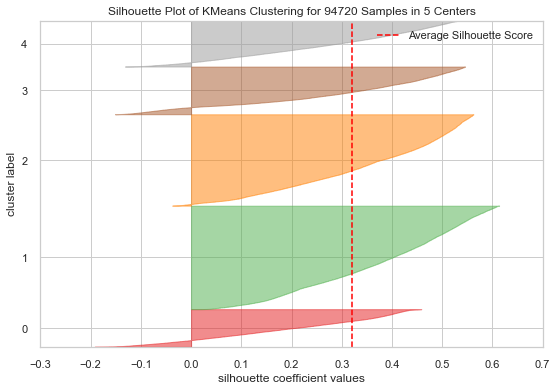

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 94720 Samples in 5 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [353]:
# Instantiate the clustering model and visualizer
model = KMeans(5)
visualizer = SilhouetteVisualizer(model)

visualizer.fit(X_F2)    # Fit the data to the visualizer
visualizer.poof()    # Draw/show/poof the data

In [354]:
print('Le silhouette score du modèle M0 est de',
      round(visualizer.silhouette_score_, 3))

Le silhouette score du modèle M0 est de 0.321


Pour regarder à quoi ressemble les clusters, j'utilise une ACP pour projeter les données sur 3 dimensions. J'utilise pour cela le module décomposition de scikit-learn.

In [355]:
pca = decomposition.PCA(n_components=2)
pca.fit(X_F2)
print(pca.explained_variance_ratio_.cumsum())
X_trans_F2 = pca.transform(X_F2)

[0.50158327 0.76192021]


J'ai affiché le pourcentage de variance expliquée par la première composante et par les deux premières composantes cumulées.

On a donc près de 76% de la variance totale qui sont expliquées par ces 2 premières composantes.

Il est donc possible d'utiliser ces deux premières composantes pour représenter les données.

J'affiche les données projetées selon ces deux dimensions, colorées selon le cluster auquel elles appartiennent, pour 5 clusters.

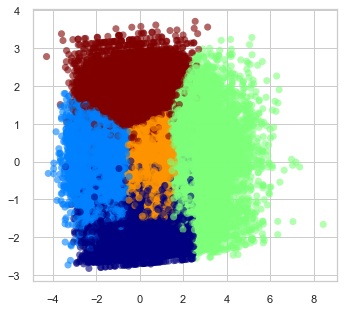

In [356]:
# je crée une figure
fig = plt.figure(figsize=(12, 5))

# Je détermine la clusterisation C0 des données F0 sur base du modèle M0
M2 = cluster.KMeans(n_clusters=5, random_state=42)
C2_new = M2.fit(X_F2)
ax = fig.add_subplot(122)
ax.scatter(X_trans_F2[:, 0], X_trans_F2[:, 1], c=M2.labels_,
           edgecolors="none", cmap="jet", alpha=0.6, s=50)

**Note :** La partie centrale de la population du graphe forme maintenant le cinquième cluster.

Comme cela se passerait dans la vie réelle, nous allons maintenant sauvegarder ce modèle **Kmeans à 5 clusters** entrainé sur les **données F0**, pour pouvoir l'utiliser plus tard et prédire les données à la partie suivante de l'analyse de la fréquence de maintenance.

Pour notre exercice, je me contenterai de **garder en mémoire vive le modèle M2**.

In [357]:
# save the model
dump(M2, open('kmeans_M2.pkl', 'wb'))

## 12.7 | Comparaison C2_new et C2_M1

In [358]:
C2_M1

array([0, 2, 4, ..., 4, 0, 2])

In [359]:
C2_new.labels_

array([3, 1, 0, ..., 3, 3, 1])

In [360]:
# Comparaison des deux clusterisations réalisées
print(metrics.adjusted_rand_score(C2_M1, C2_new.labels_))

0.8150503287868731


In [361]:
results.loc[['M_2_mths'], ['ARI_T2']
            ] = metrics.adjusted_rand_score(C2_M1, C2_new.labels_)

Le score ARI mesure le degré de similitude entre deux clusterisations.
Plus il est proche de 1, plus les individus sont classés de la même manière.

Nous souhaitions mesurer un **ARI d'au moins 0.8** pour considérer les clusterisations similaires et donc la prédiction suffisamment précise pour être maintenue durant la période retenue (ici 3 mois), ce qui est le cas.

Nous devons donc **reconsidérer la fréquence de maintenance tous les 3 mois** de la clusterisation.

# 13 | Fréquence de maintenance | Conclusion et préconisation

In [362]:
results = results.T

In [363]:
results

ARI,M_4_mths,M_3_mths,M_2_mths
ARI_T1,0.804866,0.484831,0.825092
ARI_T2,0.703949,0.769537,0.81505


<AxesSubplot:title={'center':'Evolution ARI score between T1 and T2'}>

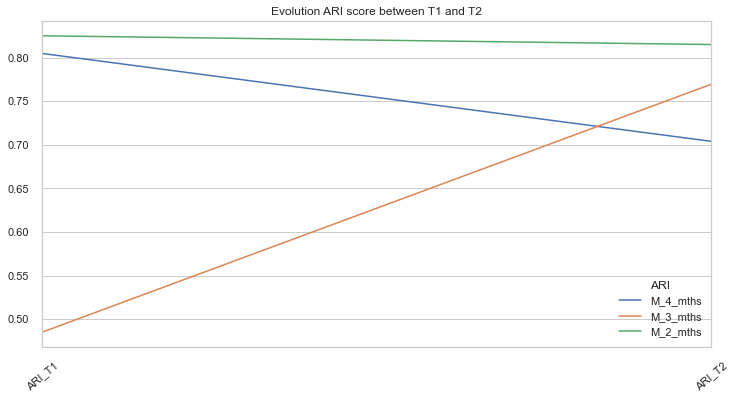

In [364]:
# we plot the results
title_graph = 'Evolution ARI score between T1 and T2'

results.plot(kind='line', title=title_graph, figsize=(
    12, 6), rot=40, xlim=['ARI_T1', 'ARI_T2'])

In [365]:
for i in range(0, 3):
    mois = results.columns[i][2]
    ari_t1 = round(results.iloc[0, i], 2)
    ari_t2 = round(results.iloc[1, i], 2)
    print('Avec une fréquence de {} mois on obtient un ARI de {} à T1 puis de {} à T2'.format(
        mois, ari_t1, ari_t2))

Avec une fréquence de 4 mois on obtient un ARI de 0.8 à T1 puis de 0.7 à T2
Avec une fréquence de 3 mois on obtient un ARI de 0.48 à T1 puis de 0.77 à T2
Avec une fréquence de 2 mois on obtient un ARI de 0.83 à T1 puis de 0.82 à T2


Sur base de ce résultat je préconise une **fréquence de maintenance de 2 mois**, qui semble être la durée sur laquelle les clusters sont les plus stables, et présentant un **ARI supérieur à 0.8**.